In [9]:
import sys
from sage.all import *
from matplotlib.pyplot import *
from matplotlib.cm import *
style.use('Solarize_Light2')

import numpy as num

x, y, z, n = var("x, y, z, n")

def plotPoints(pointList, *args):
   # Matplotlib plot les points gràce à deux liste des coordonées en x et en y resp.
   xList = [point[0] for point in pointList]
   yList = [point[1] for point in pointList]
   plot(xList, yList, *args)
def plotFunction(function : "SymbolicExpression", xrange, **kwargs):
   t = num.arange(*xrange)
   function =  fast_callable(function, vars=[x]) # Transforme l'expression symbolique en fonction numérique.
   return plot(t, function(t), **kwargs)
def plotVectorfield(function  : "SymbolicExpression", xrange, yrange):
   X, Y = num.meshgrid(num.arange(*xrange), num.arange(*yrange))

   f1 = fast_callable(function[0], vars=[x, y]) # Transforme l'expression symbolique en fonction numérique.
   f2 = fast_callable(function[1], vars=[x, y]) # Transforme l'expression symbolique en fonction numérique.

   norm = num.hypot(f1(X, Y), f2(X, Y))
   return axes.quiver(
      X, Y, f1(X, Y)/norm, f2(X, Y)/norm, norm, cmap = 'cividis'
   )
def plotStreamline(function : "SymbolicExpression", xrange, yrange):
   X, Y = num.meshgrid(num.arange(*xrange), num.arange(*yrange))

   f1 = fast_callable(function[0], vars=[x, y]) # Transforme l'expression symbolique en fonction numérique.
   f2 = fast_callable(function[1], vars=[x, y]) # Transforme l'expression symbolique en fonction numérique.

   norm = num.hypot(f1(X, Y), f2(X, Y))
   return axes.streamplot(
      X, Y, f1(X, Y), f2(X, Y), 
      density = 1.5, linewidth=1.5, color=norm,  arrowstyle='->', arrowsize=0 # type: ignore
   )
def plot3DFunction(function : "SymbolicExpression", xrange, yrange):
   X, Y = num.meshgrid(num.arange(*xrange), num.arange(*yrange))
   f = fast_callable(function, vars=[x, y]) # Transforme l'expression symbolique en fonction numérique.
   return axes.plot_surface(
      X, Y, f(X, Y), edgecolor='black', lw=0.3, rstride=1, cstride=1, alpha=0.3
   )

In [10]:
# Take a vector field, and approximate a flow line given initial conditions, and over time t
def eulerMethod(F, time, stepSize, optimizationFactor, *initialConditions): 
   n = int(num.floor(time / stepSize))     # Number of iterations necessary for achieving time t

   integralCurve = []
   partialCurveX = []
   partialCurveY = []
   P0 = vector(initialConditions)
   for i in range(n):
      partialCurveX.append((i*stepSize, P0[0]))
      partialCurveY.append((i*stepSize, P0[1]))
      integralCurve.append(P0)
      P0 = vector([numerical_approx(P0[i], digits = 10 - optimizationFactor)  for i in range(len(initialConditions))])  
      P0 = P0 + stepSize*vector(F(*P0)) # gamma(t0 + h) ~ gamma(t0) + hgamma'(t0) = gamma(t0) + hF(gamma(t0))

   return [integralCurve, partialCurveX, partialCurveY]
  
dampingCoeff = 0.5
G = lambda x, y : (y/sqrt(y**2 + (-x-dampingCoeff*y)**2), (-x-dampingCoeff*y)/sqrt(y**2 + (-x-dampingCoeff*y)**2))
H = lambda x, y : (y/(y**2 + 0.125*sin(x)**2), - 0.125 * sin(x)/(y**2 +  0.125*sin(x)**2))
I = lambda x, y : (y/(y**2 + (0.125*sin(x)+0.2*y)**2), - (0.125*sin(x)+0.2*y)/(y**2 +  (0.125*sin(x)+0.2*y)**2))

def pointListToPgfPlot(L, outputPath): # Procedure converting a list of points to a pgfplot readable data file
   with open(outputPath, 'w') as f:
      f.write('x y')
      f.write('\n')
      for line in L:
         f.write('{xvalue} {yvalue}'.format(xvalue = line[0], yvalue = line[1]))
         f.write('\n')

def computeData(dataset):
   if dataset == "springMass":
      acc = 0.005

      springMass1 = eulerMethod(G, 15, acc,0, 0.5, 0) # Longueur d'arc 12.5
      springMass2 = eulerMethod(G, 15, acc,0, 1, 0) # Longueur d'arc 13
      springMass3 = eulerMethod(G, 15, acc,0, 1.5, 0) # Longueur d'arc 13
      return [springMass1, springMass2, springMass3, dataset]
   
   if dataset == "simplePendulum":
      # Précision presque idéale 0.0035
      acc = 0.00245
      optimizationFactor = 5
      # Trajectoires apériodiques
      pendulum1 = eulerMethod(H, 15, acc,optimizationFactor, -3, 1) # Longueur d'arc 12.5
      pendulum2 = eulerMethod(H, 13, acc,optimizationFactor, -3, 0.75) # Longueur d'arc 13
      pendulum3 = eulerMethod(H, 13, acc,optimizationFactor, 9.25, -0.75) # Longueur d'arc 13
      pendulum4 = eulerMethod(H, 15, acc,optimizationFactor, 9.25, -1) # Longueur d'arc 12.5

      # Trajectoires périodiques
      pendulum5 = eulerMethod(H, 6.15, acc,optimizationFactor, 2.14, 0) # Longueur d'arc 12
      pendulum6 = eulerMethod(H, 2.575, acc,optimizationFactor, 1.14, 0) # Longueur d'arc 7
      pendulum7 = eulerMethod(H, 6.15, acc,optimizationFactor, 4.14, 0) # Longueur d'arc 12
      pendulum8 = eulerMethod(H, 2.575, acc,optimizationFactor, 5.14, 0) # Longueur d'arc 7 
      return [pendulum1, pendulum2, pendulum3, pendulum4, pendulum5, pendulum6, pendulum7, pendulum8, dataset]
   
   if dataset == "dampedSimplePendulum":
      # Précision presque idéale 0.0035
      acc = 0.002
      optimizationFactor = 5
      # Trajectoires apériodiques
      pendulum1 = eulerMethod(I, 3.975, acc,optimizationFactor, -3, 1) # Longueur d'arc 12.5
      pendulum2 = eulerMethod(I, 2.8, acc,optimizationFactor, -3, 0.75) # Longueur d'arc 13
      pendulum3 = eulerMethod(I, 2.8, acc,optimizationFactor, 9.25, -0.75) # Longueur d'arc 13
      pendulum4 = eulerMethod(I, 3.975, acc,optimizationFactor, 9.25, -1) # Longueur d'arc 12.5

      # Trajectoires périodiques
      pendulum5 = eulerMethod(I, 1.1, acc,optimizationFactor, 2.14, 0) # Longueur d'arc 12
      pendulum6 = eulerMethod(I, 0.45, acc,optimizationFactor, 1.14, 0) # Longueur d'arc 7
      pendulum7 = eulerMethod(I, 1.1, acc,optimizationFactor, 4.14, 0) # Longueur d'arc 12
      pendulum8 = eulerMethod(I, 0.45, acc,optimizationFactor, 5.14, 0) # Longueur d'arc 7 
      return [pendulum1, pendulum2, pendulum3, pendulum4, pendulum5, pendulum6, pendulum7, pendulum8, dataset]

def formatAndUpdateData(L):
   if L[-1] == "springMass": # Cas où on update les données de l'oscillateur simple
      for i in range(len(L)-1): #Accès à chaque SpringMass
         for j in range(len(L[i])): #Accès à chaque dataset d'un SpringMass
            if j == 0:
               pointListToPgfPlot(
                  L[i][j], 
                  '/home/vazn/Mathematics/LaTeX/NumericalAnalysisProjects/Oscillators/data/springMass/springMass{springNb}.dat'.format(springNb = i+1)
               )
            if j == 1:
               pointListToPgfPlot(
                  L[i][j], 
                  '/home/vazn/Mathematics/LaTeX/NumericalAnalysisProjects/Oscillators/data/springMass/springMass{springNb}partialX.dat'.format(springNb = i+1)
               )
            if j == 2:
               pointListToPgfPlot(
                  L[i][j], 
                  '/home/vazn/Mathematics/LaTeX/NumericalAnalysisProjects/Oscillators/data/springMass/springMass{springNb}partialY.dat'.format(springNb = i+1)
               )  
   if L[-1] == "simplePendulum": # Cas où on update les données du pendule simple
      for i in range(len(L)-1): # Accès à chaque pendule
         for j in range(len(L[i])): # Accès à chaque dataset d'un pendule
            if j == 0:
               pointListToPgfPlot(
                  L[i][j], 
                  '/home/vazn/Mathematics/LaTeX/NumericalAnalysisProjects/Oscillators/data/simplePendulum/undamped/pendulum{springNb}.dat'.format(springNb = i+1)
               )
            if j == 1:
               pointListToPgfPlot(
                  L[i][j], 
                  '/home/vazn/Mathematics/LaTeX/NumericalAnalysisProjects/Oscillators/data/simplePendulum/undamped/pendulum{springNb}partialX.dat'.format(springNb = i+1)
               )
            if j == 2:
               pointListToPgfPlot(
                  L[i][j], 
                  '/home/vazn/Mathematics/LaTeX/NumericalAnalysisProjects/Oscillators/data/simplePendulum/undamped/pendulum{springNb}partialY.dat'.format(springNb = i+1)
               )
   if L[-1] == "dampedSimplePendulum": # Cas où on update les données du pendule simple amorti
      for i in range(len(L)-1): # Accès à chaque pendule
         for j in range(len(L[i])): # Accès à chaque dataset d'un pendule
            if j == 0:
               pointListToPgfPlot(
                  L[i][j], 
                  '/home/vazn/Mathematics/LaTeX/NumericalAnalysisProjects/Oscillators/data/simplePendulum/damped/pendulum{springNb}.dat'.format(springNb = i+1)
               )
            if j == 1:
               pointListToPgfPlot(
                  L[i][j], 
                  '/home/vazn/Mathematics/LaTeX/NumericalAnalysisProjects/Oscillators/data/simplePendulum/damped/pendulum{springNb}partialX.dat'.format(springNb = i+1)
               )
            if j == 2:
               pointListToPgfPlot(
                  L[i][j], 
                  '/home/vazn/Mathematics/LaTeX/NumericalAnalysisProjects/Oscillators/data/simplePendulum/damped/pendulum{springNb}partialY.dat'.format(springNb = i+1)
               )

formatAndUpdateData(computeData("dampedSimplePendulum"))

FileNotFoundError: [Errno 2] No such file or directory: '/home/vazn/Mathematics/LaTeX/NumericalAnalysisProjects/Oscillators/data/simplePendulum/damped/pendulum1.dat'

<hr> 

### $$ \text{2D Plots} $$ 

<hr>

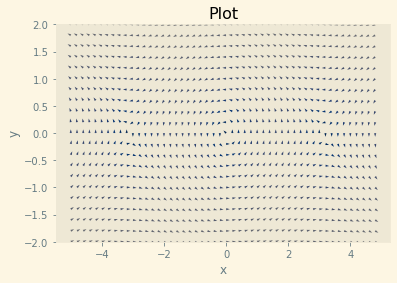

In [ ]:
# <==========================================>
fig = figure()
axes = fig.add_subplot()
axes.set_ylim([-2, 2])

grid()
xlabel("x")
ylabel("y")
title("Plot")
# <==========================================>

f = function('f')(x, n)
F = function('F')(x, y)
G = function('G')(x, y)

f = cos(x)
F = x*exp(-x**2-y**2)
G = (-y, sin(x))

xrange = (-5, 5, .2)
yrange = (-5, 5, .2)
#plotStreamline(F, (-2*num.pi, 2*num.pi, .3), (-4, 4, .3))
#plot3DFunction(F, (-2*num.pi, 2*num.pi, .3), (-4, 4, .3))

#X, Y, Z = num.meshgrid(num.arange(-2*num.pi, 2*num.pi, .5), num.arange(-2*num.pi, 2*num.pi, .5), 0)
#axes.quiver(X, Y, np.zeros_like(Z), X, Y, Z, length=0.5, color='b')

plotVectorfield(G, xrange, yrange)
#plotStreamline(F, (-2*num.pi, 2*num.pi, .3), (-4, 4, .3))

#plotFunction(f, (0.01, 10, 0.01))
#plotPoints(points, "o")

show()

<hr> 

### $$ \text{3D Plots} $$ 

<hr>

AttributeError: 'AxesSubplot' object has no attribute 'plot_surface'

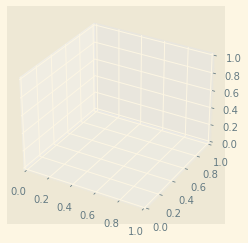

In [ ]:
fig = figure()
axes2= fig.add_subplot(111, projection='3d')
F = x*exp(-x**2-y**2)

plot3DFunction(F, (-2*num.pi, 2*num.pi, .3), (-4, 4, .3))

In [ ]:
import jupyter_manim
from manim import *
from manimScenes import *

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [ ]:
#%%manim -ql --fps 60 -v WARNING VectorFlow

config.background_color = '#242424'
config.media_embed = True

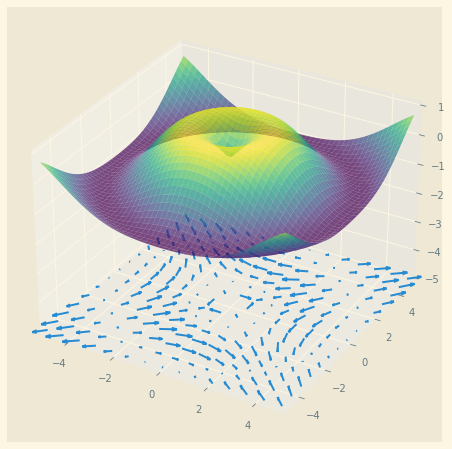

In [ ]:
# Définir la fonction à deux variables
def f(x, y):
    return num.sin(num.sqrt(x**2 + y**2))

# Créer une grille de points
x = num.linspace(-5, 5, 50)
y = num.linspace(-5, 5, 50)
X, Y = num.meshgrid(x, y)
Z = f(X, Y)

# Calculer le gradient de la fonction
def gradient(f, x, y):
    fx = num.gradient(f, axis=0)
    fy = num.gradient(f, axis=1)
    return fx, fy

# Calculer les composantes du gradient
Z_grad_x, Z_grad_y = gradient(Z, X, Y)

# Créer le plot 3D de la surface
fig = figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.7)

x = num.linspace(-5, 5, 15)
y = num.linspace(-5, 5, 15)
X, Y = num.meshgrid(x, y)
Z = f(X, Y)
Z_grad_x, Z_grad_y = gradient(Z, X, Y)

ax.quiver(X, Y, num.full_like(Z, -5), Z_grad_x, Z_grad_y, num.full_like(Z, 0), length=1)


# Définir les limites des axes
ax.set_xlim([-5, 5])
ax.set_ylim([-5, 5])
ax.set_zlim([-5, 1])
fig.canvas.toolbar_visible = False

show()

<hr> 

### $$ \text{Fourier transform} $$ 

<hr>

/tmp/ipykernel_1644/716725999.py:20: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  result, _ = quad(integrand, -T, T)


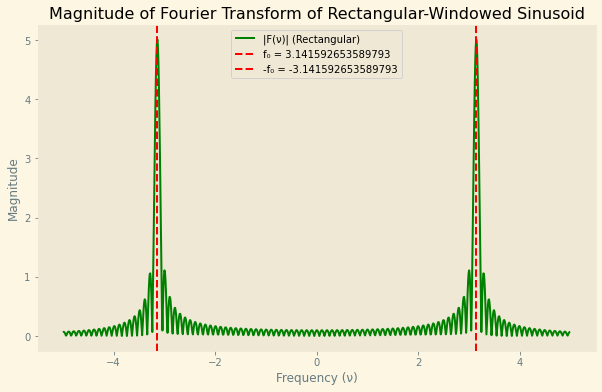

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad

# Parameters
f0 = num.pi  # Frequency of the sinusoidal part
T = 5   # Width of the rectangular window
nu = np.arange(-5, 5, 0.01)  # Frequency range for the Fourier Transform

# Define the rectangular-windowed sinusoid
def rectangular_window(t, T):
    return 1 if -T <= t <= T else 0

def sin_rectangular(t, f0, T):
    return rectangular_window(t, T) * np.cos(2 * np.pi * f0 * t)

# Fourier Transform components
def fourier_real_rect(nu, f0, T):
    integrand = lambda t: rectangular_window(t, T) * np.cos(2 * np.pi * f0 * t) * np.cos(2 * np.pi * nu * t)
    result, _ = quad(integrand, -T, T)
    return result

def fourier_imag_rect(nu, f0, T):
    integrand = lambda t: rectangular_window(t, T) * np.cos(2 * np.pi * f0 * t) * -np.sin(2 * np.pi * nu * t)
    result, _ = quad(integrand, -T, T)
    return result

# Compute the Fourier Transform
real_part_rect = np.array([fourier_real_rect(n, f0, T) for n in nu])
imag_part_rect = np.array([fourier_imag_rect(n, f0, T) for n in nu])
magnitude_rect = np.sqrt(real_part_rect**2 + imag_part_rect**2)

# Plot the magnitude of the Fourier Transform
plt.figure(figsize=(10, 6))
plt.plot(nu, magnitude_rect, label='|F(ν)| (Rectangular)', color='green')
plt.title("Magnitude of Fourier Transform of Rectangular-Windowed Sinusoid")
plt.xlabel("Frequency (ν)")
plt.ylabel("Magnitude")
plt.axvline(f0, color='red', linestyle='--', label=f"f₀ = {f0}")
plt.axvline(-f0, color='red', linestyle='--', label=f"-f₀ = {-f0}")
plt.legend()
plt.grid()
plt.show()

In [10]:
# Méthode du gradient pour les fonctions QUADRATIQUES. Sinon la fonction gradf ne représente rien
# Et surtout ne représente pas le gradient.
def gradientMethods(x0, b, error, maxIt, method, prodMatrix):  
    gradf = lambda x : prodMatrix(x)-b
  
    if method == "pasFixe":
        iterFunction = lambda x : x-0.25*gradf(x)
    elif method == "pasOptimal":
        # Formule donnée par le cours pour le pas optimal
        pasOptimal = lambda x : (gradf(x).transpose() * gradf(x)) / (gradf(x).transpose() * prodMatrix(gradf(x)))
        # On recalcule le pas optimal au point courant à chaque itération.
        # C'est un matrice (1, 1) donc on doit prendre sa seule composante car sage ne gère pas l'opération sinon.
        iterFunction = lambda x : x-pasOptimal(x)[0,0]*gradf(x)

    i = 0
    while(i < maxIt and (prodMatrix(x0)-b).norm(2) > error):
        x0 = iterFunction(x0)
        i = i + 1
        
    return (x0, i)

def testMethods(dimension, error, maxIt, method, textOutput):
    # Vecteur initial
    x0 = Matrix(RR, [[0] for i in range(dimension)])
    # Second membre
    b = Matrix(RR, [[i] for i in range(dimension)])

    def prodA(u):
        v = Matrix(RR,dimension,1)
        v[0,0] = 2.0*u[0][0] - u[1][0]
        for i in range(1,dimension-1):
            v[i,0] = -u[i-1][0] +2.0*u[i][0] - u[i+1][0]
        v[dimension-1,0] = -u[dimension-2][0] +2.0*u[dimension-1][0]
        return v
    
    sol, itNumber = gradientMethods(x0, b, error, maxIt, method, prodA)
    if textOutput == True:
        print(
            sol, 
            "\n\n", "La solution est valide: {bool} \n La solution est atteinte en {count} itérations.".format(
                bool = True if (prodA(sol) - b).norm() < 10^(-5) else False, 
                count = itNumber
            )
        )
    return itNumber

print('<<============= GRADIENT PAS FIXE ==============>\n')
testMethods(10, 10^(-3), 10000, "pasFixe", textOutput = True)
print('\n<<============= GRADIENT PAS OPTIMAL ==============>\n')
testMethods(10, 10^(-3), 10000, "pasOptimal", textOutput = True)


print('\n<<============= COMPARAISON DES METHODES ==============>\n')
L1 = [testMethods(i, 10^(-3), 5000, "pasFixe", textOutput = False) for i in [10, 20, 30, 40, 50]]
L2 = [testMethods(i, 10^(-3), 5000, "pasOptimal", textOutput = False) for i in [10, 20, 30, 40, 50]]

print(L1, '\n', L2)

<<============= GRADIENT PAS FIXE ==============>

[14.9999999852015]
[29.9999999716018]
[43.9999999603029]
[55.9999999522199]
[64.9999999480078]
[69.9999999480078]
[69.9999999522199]
[63.9999999603029]
[50.9999999716018]
[29.9999999852015] 

 La solution est valide: True 
 La solution est atteinte en 1027 itérations.

<<============= GRADIENT PAS OPTIMAL ==============>

[14.9999999900378]
[29.9999999801341]
[43.9999999732762]
[55.9999999665756]
[64.9999999649993]
[69.9999999636290]
[69.9999999678349]
[63.9999999722300]
[50.9999999808826]
[29.9999999896477] 

 La solution est valide: True 
 La solution est atteinte en 508 itérations.

<<============= COMPARAISON DES METHODES ==============>

[465, 1889, 4358, 5000, 5000] 
 [230, 956, 2220, 4044, 5000]
